In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, roc_auc_score, classification_report
import shap

c:\Users\samyo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss, roc_auc_score, classification_report
from xgboost import XGBClassifier

# Suppress specific XGBoost warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

# Load the processed dataset
file_path = 'model_data.csv'  # Update this with your local file path
original_data = pd.read_csv(file_path)

# Create a copy of the original data for processing
data = original_data.copy()

# Create the target variable based on shot_outcome
data['shot_outcome'] = data['shot_outcome'].apply(lambda x: 1 if x == 'Goal' else 0)

# Drop the columns that are not needed for the model
data = data.drop(columns=['location', 'period', 'statsbomb_xg', 'possession_team', 'player'])

# Handle categorical variables including 'position'
data = pd.get_dummies(data, drop_first=True)

# Define the features and target variable
X = data.drop(columns=['shot_outcome'])
y = data['shot_outcome']

# Split the dataset into training (60%) and testing (40%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Scale the features using Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 6, 9],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5]
# }

param_grid = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'max_depth': [3],
    'subsample': [1.0],
    'colsample_bytree': [1.0],
    'gamma': [0.2],
    'min_child_weight': [1]
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(eval_metric='logloss')

# Perform grid search with cross-validation
grid_search = GridSearchCV(xgb_model, param_grid, cv=5, scoring='neg_log_loss', verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Get the best model from grid search
best_model = grid_search.best_estimator_

# Predict the xG values for the entire dataset (including the training set)
X_scaled = scaler.transform(X)
calculated_xg = best_model.predict_proba(X_scaled)[:, 1]
calculated_xg = calculated_xg.round(7)

# Add the calculated xG values back to the original dataframe
original_data['calculated_xg'] = calculated_xg

# Save the dataset with calculated xG values back to the same file
output_file_path = 'model_data_with_calculated_xg.csv'
original_data.to_csv(output_file_path, index=False)

# Evaluate the model
y_pred_prob = best_model.predict_proba(X_test_scaled)[:, 1]
log_loss_score = log_loss(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)
y_pred = best_model.predict(X_test_scaled)
report = classification_report(y_test, y_pred)

# Display the evaluation metrics
print(f'Log Loss: {log_loss_score}')
print(f'ROC AUC Score: {roc_auc}')
print('Classification Report:')
print(report)

# Display the best parameters found by grid search
print('Best Parameters:', grid_search.best_params_)

# Display the first few rows of the dataframe with calculated xG values
print(original_data.head(10))


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Log Loss: 0.1596397254701293
ROC AUC Score: 0.9552430555555556
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       600
           1       0.67      0.67      0.67        72

    accuracy                           0.93       672
   macro avg       0.81      0.81      0.81       672
weighted avg       0.93      0.93      0.93       672

Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1.0}
    possession_team                         player    position       location  \
0   Morocco Women's                Ibtissam Jraïdi     Forward  [115.6, 23.1]   
1  Colombia Women's  Mayra Tatiana Ramírez Ramírez     Forward  [113.6, 54.5]   
2   Morocco Women's                Ibtissam Jraïdi     Forward  [107.8, 33.7]   
3  Colombia Women's     María Catalina Usme Pi

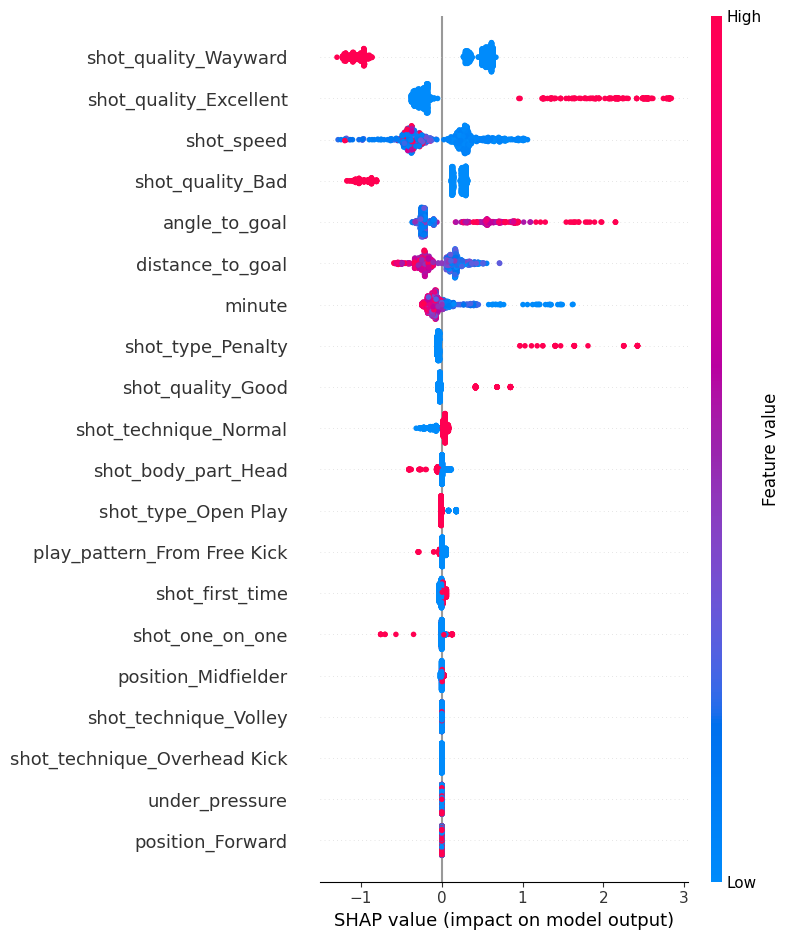

    possession_team                         player    position       location  \
0   Morocco Women's                Ibtissam Jraïdi     Forward  [115.6, 23.1]   
1  Colombia Women's  Mayra Tatiana Ramírez Ramírez     Forward  [113.6, 54.5]   
2   Morocco Women's                Ibtissam Jraïdi     Forward  [107.8, 33.7]   
3  Colombia Women's     María Catalina Usme Pineda  Midfielder  [103.2, 74.4]   
4  Colombia Women's         Daniela Montoya Quiróz  Midfielder  [111.0, 39.3]   

   distance_to_goal  angle_to_goal  shot_speed    play_pattern  shot_type  \
0          17.75387        6.09144    37.28771    Regular Play  Open Play   
1          15.57562       11.55180    22.60042    Regular Play  Open Play   
2          13.87083       26.51428    11.62217    Regular Play  Open Play   
3          38.01381        4.90953    18.59899  From Free Kick  Free Kick   
4           9.05539       43.83945   429.42998   From Throw In  Open Play   

   minute  period  under_pressure shot_body_part  

In [15]:
# SHAP value analysis
explainer = shap.Explainer(best_model, X_train_scaled)
shap_values = explainer(X_train_scaled)

# Plot the SHAP summary
shap.summary_plot(shap_values, X_train, feature_names=X.columns.tolist())

# Display the first few rows of the dataframe with calculated xG values
print(original_data.head())
